In [63]:
# Mount google drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import r2_score
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [70]:
bond_price_complete = pd.read_csv("/content/drive/MyDrive/UMDatathon/bond_price_complete.csv")
bond_price_complete = bond_price_complete.iloc[:,1:]
bond_price_complete

,Date,Price,Open,High,Low,Change %,Overnight,Stock_Price
0,2015-01-27,3.907,3.911,3.911,3.907,-0.10%,3.25,15.00
1,2015-01-28,3.863,3.902,3.902,3.862,-1.13%,3.25,14.80
2,2015-01-29,3.861,3.862,3.867,3.858,-0.05%,3.25,14.56
3,2015-01-30,3.809,3.856,3.856,3.809,-1.35%,3.24,14.50
4,2015-02-01,3.809,3.809,3.809,3.809,0.00%,3.24,14.50
...,...,...,...,...,...,...,...,...
2607,2023-10-08,4.162,4.175,4.175,4.162,0.77%,2.96,10.02
2608,2023-10-09,4.118,4.139,4.139,4.118,-1.06%,3.00,9.97
2609,2023-10-10,4.101,4.118,4.118,4.101,-0.41%,3.00,9.97
2610,2023-10-11,4.069,4.101,4.101,4.069,-0.78%,2.96,9.99


Text(0.5, 0, 'Date')

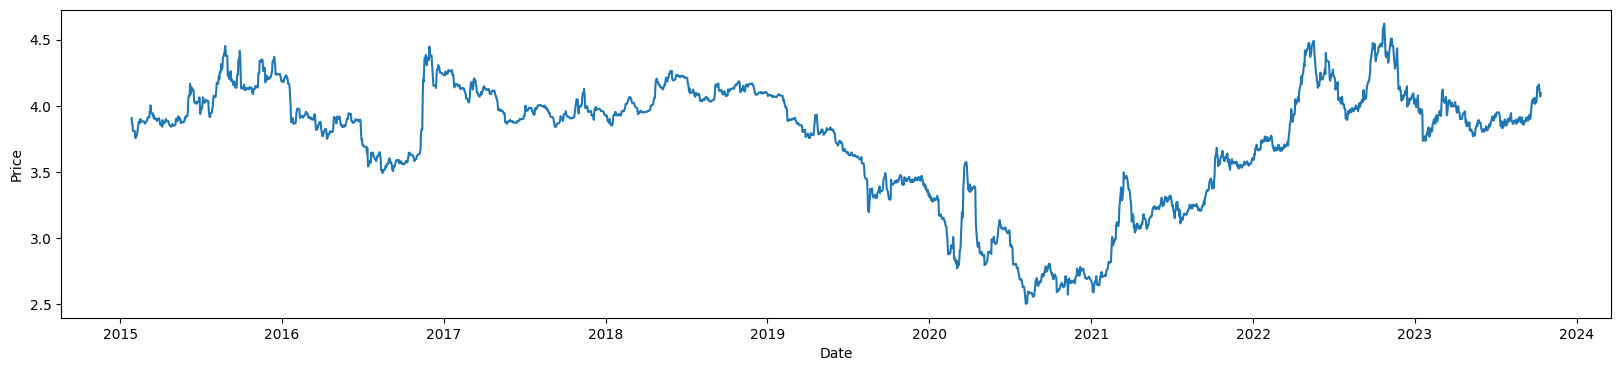

In [ ]:
bond_price_complete.sort_values(by=['Date'],inplace=True)
plt.figure(figsize=(20,4))
plt.plot(bond_price_complete['Date'],bond_price_complete['Price'])
plt.ylabel("Price")
plt.xlabel("Date")

In [71]:
bond_price_complete['Date'] = pd.to_datetime(bond_price_complete['Date'])
bond_price_complete.dtypes

Date           datetime64[ns]
Price                 float64
Open                  float64
High                  float64
Low                   float64
Change %               object
Overnight             float64
Stock_Price           float64
dtype: object

In [72]:
# How many days of previous stock data are used to predict the next day
time_steps = 100

# Train-test split
# Training set (from start to 31/12/2021)
# Test set (from 1/1/2022 to end)
train_df = bond_price_complete[bond_price_complete["Date"] <= pd.Timestamp("2022-12-31")].reset_index(drop=True)
test_df = bond_price_complete.iloc[len(train_df) - time_steps:, :].reset_index(drop=True)

print(train_df.shape)
print(test_df.shape)

(2382, 8)
(330, 8)


In [90]:
train_df

,Date,Price,Open,High,Low,Change %,Overnight,Stock_Price
0,2015-01-27,3.907,3.911,3.911,3.907,-0.10%,3.25,15.00
1,2015-01-28,3.863,3.902,3.902,3.862,-1.13%,3.25,14.80
2,2015-01-29,3.861,3.862,3.867,3.858,-0.05%,3.25,14.56
3,2015-01-30,3.809,3.856,3.856,3.809,-1.35%,3.24,14.50
4,2015-02-01,3.809,3.809,3.809,3.809,0.00%,3.24,14.50
...,...,...,...,...,...,...,...,...
2377,2022-12-26,4.079,4.079,4.079,4.079,0.82%,2.74,9.17
2378,2022-12-27,4.073,4.073,4.073,4.073,-0.15%,2.75,9.24
2379,2022-12-28,4.092,4.092,4.092,4.092,0.47%,2.75,9.30
2380,2022-12-29,4.093,4.092,4.093,4.092,0.02%,2.75,9.46


In [73]:
train_data_raw = np.array(train_df[['Open', 'High', 'Low', 'Price']])
test_data_raw = np.array(test_df[['Open', 'High', 'Low', 'Price']])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_data_raw)

train_data_scaled = scaler.transform(train_data_raw)
test_data_scaled = scaler.transform(test_data_raw)

In [74]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

In [75]:
X_train, y_train = create_dataset(train_data_scaled, time_step=time_steps)
X_test, y_test = create_dataset(test_data_scaled, time_step=time_steps)

In [76]:
print(X_train.shape) # (m, t, n)    n has ['Open', 'High', 'Low', 'Price']
print(y_train.shape) # (m, n)
print(X_test.shape) # (m, t, n)    n has ['Open', 'High', 'Low', 'Price']
print(y_test.shape) # (m, n)


(2281, 100, 4)
(2281, 4)
(229, 100, 4)
(229, 4)


In [88]:
X_train

array([[[0.667295  , 0.63739249, 0.66540999, 0.66320755],
        [0.66305372, 0.63331824, 0.64420358, 0.64245283],
        [0.64420358, 0.61747397, 0.64231857, 0.64150943],
        ...,
        [0.66682375, 0.64146673, 0.66682375, 0.66933962],
        [0.67153629, 0.64146673, 0.67153629, 0.66933962],
        [0.67153629, 0.64146673, 0.67153629, 0.66933962]],

       [[0.66305372, 0.63331824, 0.64420358, 0.64245283],
        [0.64420358, 0.61747397, 0.64231857, 0.64150943],
        [0.64137606, 0.61249434, 0.61922714, 0.61698113],
        ...,
        [0.67153629, 0.64146673, 0.67153629, 0.66933962],
        [0.67153629, 0.64146673, 0.67153629, 0.66933962],
        [0.67200754, 0.64191942, 0.67106503, 0.66886792]],

       [[0.64420358, 0.61747397, 0.64231857, 0.64150943],
        [0.64137606, 0.61249434, 0.61922714, 0.61698113],
        [0.61922714, 0.59121775, 0.61922714, 0.61698113],
        ...,
        [0.67153629, 0.64146673, 0.67153629, 0.66933962],
        [0.67200754, 0.641919

In [78]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(4))
model.compile(loss='mean_squared_error', optimizer='adam')

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 64)           17664     
                                                                 
 lstm_7 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 83972 (328.02 KB)
Trainable params: 83972 (328.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=10, verbose=1)

Epoch 1/10
229/229 [==============================] - 43s 155ms/step - loss: 0.0098 - val_loss: 0.0017
Epoch 2/10
229/229 [==============================] - 35s 151ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 3/10
229/229 [==============================] - 37s 162ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 4/10
229/229 [==============================] - 33s 145ms/step - loss: 0.0011 - val_loss: 4.5038e-04
Epoch 5/10
229/229 [==============================] - 33s 146ms/step - loss: 8.9081e-04 - val_loss: 5.1032e-04
Epoch 6/10
229/229 [==============================] - 35s 153ms/step - loss: 6.8708e-04 - val_loss: 3.5805e-04
Epoch 7/10
229/229 [==============================] - 33s 146ms/step - loss: 5.2291e-04 - val_loss: 3.5852e-04
Epoch 8/10
229/229 [==============================] - 33s 145ms/step - loss: 4.2159e-04 - val_loss: 3.1757e-04
Epoch 9/10
229/229 [==============================] - 34s 149ms/step - loss: 3.4758e-04 - val_loss: 3.1410e-04
Epoch 10/10
229/229 [========

In [81]:
model_mse = model.evaluate(X_test, y_test)
print(model_mse)

8/8 [==============================] - 0s 42ms/step - loss: 3.0000e-04
0.0002999950374942273


In [83]:
# Evaluation using RSquared
model_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
print(model_r2)

0.8121719474403697


In [82]:
y_test_pred = model.predict(X_test)

8/8 [==============================] - 2s 57ms/step


In [84]:
y_test_pred_unscaled = scaler.inverse_transform(y_test_pred)
test_pred_df = pd.DataFrame(y_test_pred_unscaled, columns=['Open', 'High', 'Low', 'Price'])
test_pred_df["Date"] = test_df["Date"][test_df["Date"] > pd.Timestamp("2023-1-2")].values
test_pred_df = test_pred_df[['Date', 'Open', 'High', 'Low', 'Price']]
test_pred_df

,Date,Open,High,Low,Price
0,2023-01-03,4.023300,4.053303,4.013846,4.027930
1,2023-01-04,4.012305,4.036365,4.002497,4.016180
2,2023-01-05,3.994962,4.016913,3.985085,3.998951
3,2023-01-06,3.977729,3.998685,3.968247,3.982320
4,2023-01-08,3.981842,4.002248,3.973150,3.988114
...,...,...,...,...,...
224,2023-10-08,4.118583,4.150072,4.109440,4.131842
225,2023-10-09,4.126082,4.164161,4.116677,4.138833
226,2023-10-10,4.138102,4.176539,4.128024,4.149267
227,2023-10-11,4.102517,4.140345,4.090892,4.110342


In [ ]:
model.predict()

In [85]:
test_actual_df = test_df[time_steps + 1:].reset_index(drop=True)

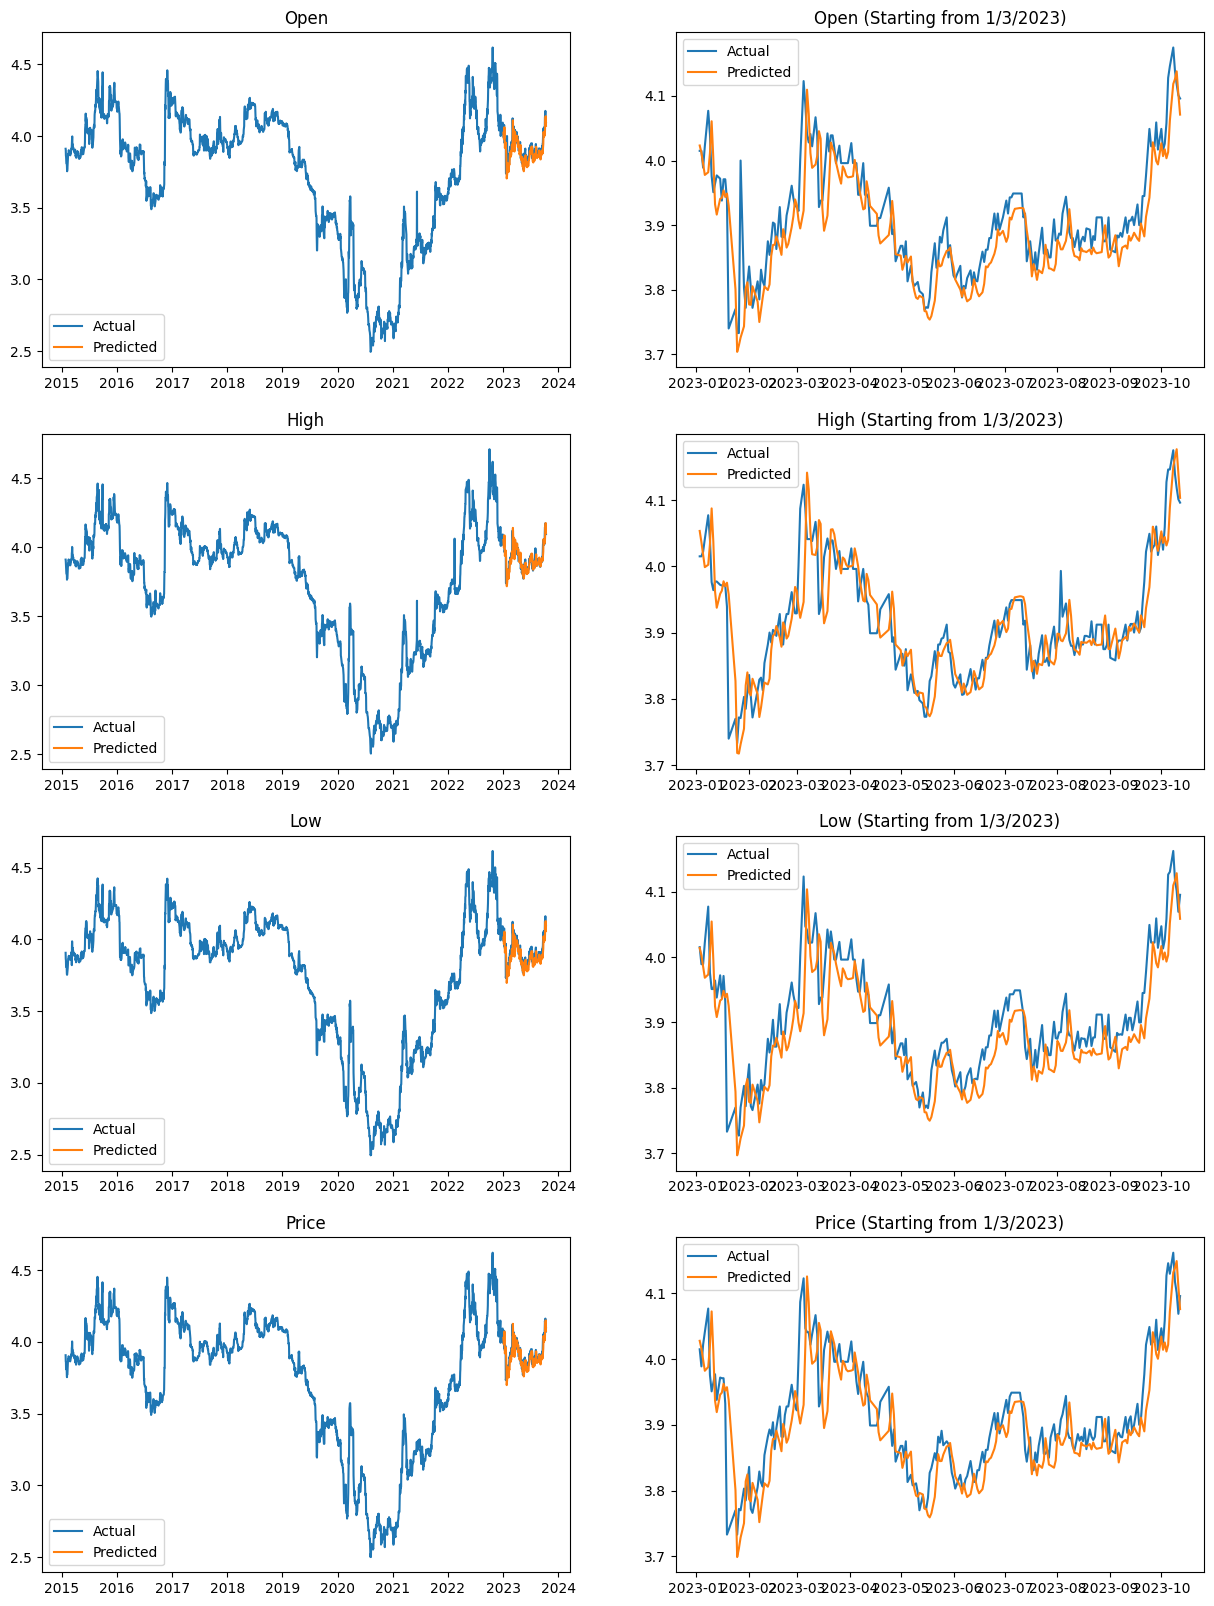

In [86]:
fig, axes =  plt.subplots(4, 2, figsize=(15, 4 * 5))

for idx, feature in enumerate(['Open', 'High', 'Low', 'Price']):
    actual_date = list(train_df["Date"].values)
    actual_date.extend(list(test_actual_df["Date"].values))
    actual_feature = list(train_df[feature].values)
    actual_feature.extend(list(test_actual_df[feature].values))

    axes[idx][0].plot(actual_date, actual_feature, label="Actual")
    axes[idx][0].plot(test_pred_df["Date"].values, test_pred_df[feature].values, label="Predicted")
    axes[idx][0].set_title(feature)
    axes[idx][0].legend()

    axes[idx][1].plot(test_actual_df["Date"].values, test_actual_df[feature].values, label="Actual")
    axes[idx][1].plot(test_pred_df["Date"].values, test_pred_df[feature].values, label="Predicted")
    axes[idx][1].set_title(f"{feature} (Starting from 1/3/2023)")
    axes[idx][1].legend()

plt.show()

In [89]:
test_pred_df.to_csv("/content/drive/MyDrive/UMDatathon/predicted.csv")

In [91]:
train_df

,Date,Price,Open,High,Low,Change %,Overnight,Stock_Price
0,2015-01-27,3.907,3.911,3.911,3.907,-0.10%,3.25,15.00
1,2015-01-28,3.863,3.902,3.902,3.862,-1.13%,3.25,14.80
2,2015-01-29,3.861,3.862,3.867,3.858,-0.05%,3.25,14.56
3,2015-01-30,3.809,3.856,3.856,3.809,-1.35%,3.24,14.50
4,2015-02-01,3.809,3.809,3.809,3.809,0.00%,3.24,14.50
...,...,...,...,...,...,...,...,...
2377,2022-12-26,4.079,4.079,4.079,4.079,0.82%,2.74,9.17
2378,2022-12-27,4.073,4.073,4.073,4.073,-0.15%,2.75,9.24
2379,2022-12-28,4.092,4.092,4.092,4.092,0.47%,2.75,9.30
2380,2022-12-29,4.093,4.092,4.093,4.092,0.02%,2.75,9.46


In [93]:
train_df = train_df[['Date','Open','High','Low','Price']]
train_df

,Date,Open,High,Low,Price
0,2015-01-27,3.911,3.911,3.907,3.907
1,2015-01-28,3.902,3.902,3.862,3.863
2,2015-01-29,3.862,3.867,3.858,3.861
3,2015-01-30,3.856,3.856,3.809,3.809
4,2015-02-01,3.809,3.809,3.809,3.809
...,...,...,...,...,...
2377,2022-12-26,4.079,4.079,4.079,4.079
2378,2022-12-27,4.073,4.073,4.073,4.073
2379,2022-12-28,4.092,4.092,4.092,4.092
2380,2022-12-29,4.092,4.093,4.092,4.093


In [94]:
train_df.to_csv("/content/drive/MyDrive/UMDatathon/actual.csv")